In [12]:
%matplotlib inline

import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import *


import initspark

In [13]:
spark = SparkSession.builder.appName("TaxiData").getOrCreate()

schema = StructType([
    StructField("date", StringType()),
    StructField("lat", DoubleType()),
    StructField("lon", DoubleType()),
    StructField("base", StringType())
])

csv = spark.read.option("header", "true").csv("./data/uber/*.csv", schema = schema).cache()

In [14]:
csv.show()

+----------------+-------+--------+------+
|            date|    lat|     lon|  base|
+----------------+-------+--------+------+
|9/1/2014 0:01:00|40.2201|-74.0021|B02512|
|9/1/2014 0:01:00|  40.75|-74.0027|B02512|
|9/1/2014 0:03:00|40.7559|-73.9864|B02512|
|9/1/2014 0:06:00| 40.745|-73.9889|B02512|
|9/1/2014 0:11:00|40.8145|-73.9444|B02512|
|9/1/2014 0:12:00|40.6735|-73.9918|B02512|
|9/1/2014 0:15:00|40.7471|-73.6472|B02512|
|9/1/2014 0:16:00|40.6613|-74.2691|B02512|
|9/1/2014 0:32:00|40.3745|-73.9999|B02512|
|9/1/2014 0:33:00|40.7633|-73.9773|B02512|
|9/1/2014 0:33:00|40.7467|-73.6131|B02512|
|9/1/2014 0:37:00|40.8105|  -73.96|B02512|
|9/1/2014 0:38:00| 40.679|-74.0111|B02512|
|9/1/2014 0:39:00|40.4023|-73.9839|B02512|
|9/1/2014 0:48:00|40.7378|-74.0395|B02512|
|9/1/2014 0:48:00|40.7214|-73.9884|B02512|
|9/1/2014 0:49:00|40.8646|-73.9081|B02512|
|9/1/2014 1:08:00|40.7398|-74.0061|B02512|
|9/1/2014 1:17:00|40.6793|-74.0116|B02512|
|9/1/2014 1:19:00|40.7328|-73.9875|B02512|
+----------

In [15]:
csv.count()

4534327

In [16]:
csv.printSchema()

root
 |-- date: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- base: string (nullable = true)



In [17]:
from datetime import datetime

dateItem = "8/1/2014 0:36:00"

print(datetime.strptime("8/1/2014 0:36:00", "%m/%d/%Y %H:%M:%S"))

2014-08-01 00:36:00


In [18]:
from pyspark.sql.functions import udf

f = udf(lambda x: datetime.strptime(x, "%m/%d/%Y %H:%M:%S"), TimestampType())

In [19]:
csv.withColumn("date", f(csv.date)).printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- base: string (nullable = true)



In [20]:
data = csv.withColumn("date", f(csv.date))

PySpark SQL - Dokumentation: http://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html

In [21]:
data.show()

+--------------------+-------+--------+------+
|                date|    lat|     lon|  base|
+--------------------+-------+--------+------+
|2014-09-01 00:01:...|40.2201|-74.0021|B02512|
|2014-09-01 00:01:...|  40.75|-74.0027|B02512|
|2014-09-01 00:03:...|40.7559|-73.9864|B02512|
|2014-09-01 00:06:...| 40.745|-73.9889|B02512|
|2014-09-01 00:11:...|40.8145|-73.9444|B02512|
|2014-09-01 00:12:...|40.6735|-73.9918|B02512|
|2014-09-01 00:15:...|40.7471|-73.6472|B02512|
|2014-09-01 00:16:...|40.6613|-74.2691|B02512|
|2014-09-01 00:32:...|40.3745|-73.9999|B02512|
|2014-09-01 00:33:...|40.7633|-73.9773|B02512|
|2014-09-01 00:33:...|40.7467|-73.6131|B02512|
|2014-09-01 00:37:...|40.8105|  -73.96|B02512|
|2014-09-01 00:38:...| 40.679|-74.0111|B02512|
|2014-09-01 00:39:...|40.4023|-73.9839|B02512|
|2014-09-01 00:48:...|40.7378|-74.0395|B02512|
|2014-09-01 00:48:...|40.7214|-73.9884|B02512|
|2014-09-01 00:49:...|40.8646|-73.9081|B02512|
|2014-09-01 01:08:...|40.7398|-74.0061|B02512|
|2014-09-01 0

In [22]:
import pyspark.sql.functions as F

In [28]:
data.groupBy(F.date_format(data.date, "H")).count()

DataFrame[date_format(date, H): string, count: bigint]

In [29]:
dataPerHour = data\
    .groupBy(F.date_format(data.date, "H"))\
    .count()\
    .orderBy("date_format(date, H)")\
    .cache()

In [32]:
dataPerHour\
    .withColumn("hour", dataPerHour["date_format(date, H)"].cast(IntegerType()))\
    .orderBy("hour")\
    .show()

+--------------------+------+----+
|date_format(date, H)| count|hour|
+--------------------+------+----+
|                   0|103836|   0|
|                   1| 67227|   1|
|                   2| 45865|   2|
|                   3| 48287|   3|
|                   4| 55230|   4|
|                   5| 83939|   5|
|                   6|143213|   6|
|                   7|193094|   7|
|                   8|190504|   8|
|                   9|159967|   9|
|                  10|159148|  10|
|                  11|165703|  11|
|                  12|170452|  12|
|                  13|195877|  13|
|                  14|230625|  14|
|                  15|275466|  15|
|                  16|313400|  16|
|                  17|336190|  17|
|                  18|324679|  18|
|                  19|294513|  19|
+--------------------+------+----+
only showing top 20 rows



In [31]:
dataPerHourFetched = dataPerHour\
    .withColumn("hour", dataPerHour["date_format(date, H)"].cast(IntegerType()))\
    .orderBy("hour")\
    .collect()

In [61]:
print(dataPerHourFetched)

[Row(date_format(date, H)='0', count=103836, hour=0), Row(date_format(date, H)='1', count=67227, hour=1), Row(date_format(date, H)='2', count=45865, hour=2), Row(date_format(date, H)='3', count=48287, hour=3), Row(date_format(date, H)='4', count=55230, hour=4), Row(date_format(date, H)='5', count=83939, hour=5), Row(date_format(date, H)='6', count=143213, hour=6), Row(date_format(date, H)='7', count=193094, hour=7), Row(date_format(date, H)='8', count=190504, hour=8), Row(date_format(date, H)='9', count=159967, hour=9), Row(date_format(date, H)='10', count=159148, hour=10), Row(date_format(date, H)='11', count=165703, hour=11), Row(date_format(date, H)='12', count=170452, hour=12), Row(date_format(date, H)='13', count=195877, hour=13), Row(date_format(date, H)='14', count=230625, hour=14), Row(date_format(date, H)='15', count=275466, hour=15), Row(date_format(date, H)='16', count=313400, hour=16), Row(date_format(date, H)='17', count=336190, hour=17), Row(date_format(date, H)='18', cou

In [62]:
x = []
y = []
for row in dataPerHourFetched:
    x.append(row["date_format(date, H)"])
    y.append(row["count"])


In [63]:
%matplotlib inline

import matplotlib.pyplot as plt

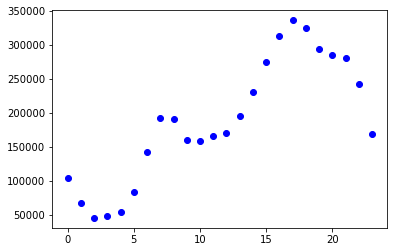

In [66]:
plt.plot(x, y, 'bo')
plt.show()

## Aufgabe!

Wie sieht dieses Diagramm über die Wochentage aus? 
An welchem Wochentag gibt es am meisten Nachfrage nach einem Uber?

Hinweis: Schau dir die Parameter - Liste für die date_format - Funktion am Besten in der Dokumentation für Java 7+ an (http://docs.oracle.com/javase/7/docs/api/java/text/SimpleDateFormat.html), dann hast du die Möglichkeit, den Tag in der Woche als Zahl (1 = Montag, ..., 7 = Sonntag) zu bekommen. Das vereinfacht die Grafik!

In [70]:
dataPerDoW = data\
    .groupBy(F.date_format(data.date, "u"))\
    .count()\
    .orderBy("date_format(date, u)")\
    .cache()

In [71]:
dataPerDoW\
    .withColumn("DoW", dataPerDoW["date_format(date, u)"].cast(IntegerType()))\
    .orderBy("DoW")\
    .show()


+--------------------+------+---+
|date_format(date, u)| count|DoW|
+--------------------+------+---+
|                   1|541472|  1|
|                   2|663789|  2|
|                   3|696488|  3|
|                   4|755145|  4|
|                   5|741139|  5|
|                   6|646114|  6|
|                   7|490180|  7|
+--------------------+------+---+



In [72]:
rows = dataPerDoW\
    .withColumn("DoW", dataPerDoW["date_format(date, u)"].cast(IntegerType()))\
    .collect()

In [73]:
x = []
y = []
for row in rows:
    x.append(row["date_format(date, u)"])
    y.append(row["count"])


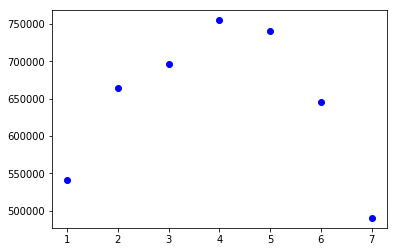

In [76]:
plt.plot(x, y, "bo")
plt.show()